In [1]:
import pydicom as dcm
from matplotlib import pyplot as plt, pylab as plb
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL.Image as Image

In [2]:
%matplotlib inline
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def preprocess_dcm(file_path):
    ds = dcm.dcmread(file_path)
    ds = ds.pixel_array.astype(np.float32)# / np.max(np.abs(ds.pixel_array))
    return ds

In [4]:
img_dir = '/home/jupyter/rsna-intracranial-hemorrhage-detection/stage_2_train/'

## First, look at a random image's edgemap

In [5]:
ind = np.random.randint(100000)
img_path = os.listdir('/home/jupyter/rsna-intracranial-hemorrhage-detection/stage_2_train/')[ind]

In [6]:
arr = preprocess_dcm(img_dir + img_path)
arr = tf.convert_to_tensor(np.expand_dims(arr, axis=(0,3)))
sobel = tf.image.sobel_edges(arr)
sobel_y = np.asarray(sobel[0, :, :, :, 0]) # sobel in y-direction
sobel_x = np.asarray(sobel[0, :, :, :, 1]) # sobel in x-direction

2021-11-29 06:50:46.252620: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 06:50:46.823371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38444 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-11-29 06:50:48.264879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


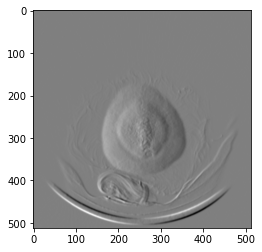

In [7]:
plb.imshow(np.asarray(Image.fromarray(sobel_y[..., 0] / 4 + 0.5)), cmap='gray')
plb.imshow(np.asarray(Image.fromarray(sobel_x[..., 0] / 4 + 0.5)), cmap='gray')

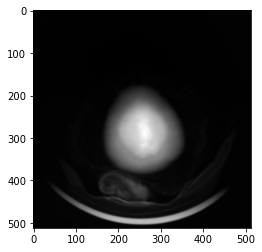

In [8]:
orig = preprocess_dcm('/home/jupyter/rsna-intracranial-hemorrhage-detection/stage_2_train/' + img_path)
plb.imshow(orig, cmap='gray')

We can see that the edgemap sufficiently finds the edges in the scan which may be easily missed by the human eye, which will be the indicator if hemorrhage. This means that edge detection may be very useful in classification

## Next, view edgemaps for a member of each of the 6 classes

In [9]:
def get_edge_map(img):
    sobel = tf.image.sobel_edges(img)
    sobel_y = np.asarray(sobel[0, :, :, :, 0]) # sobel in y-direction
    sobel_x = np.asarray(sobel[0, :, :, :, 1]) # sobel in x-direction
    return sobel_y, sobel_x
def plot_edge_map(sobel_y, sobel_x):
    plb.imshow(np.asarray(Image.fromarray(sobel_y[..., 0] / 4 + 0.5)), cmap='gray')
    plb.imshow(np.asarray(Image.fromarray(sobel_x[..., 0] / 4 + 0.5)), cmap='gray')

In [10]:
labels = pd.read_csv('/home/jupyter/rsna-intracranial-hemorrhage-detection/train_labels.csv', index_col=0)

### (1) A scan with no hemorrhage

In [11]:
none = labels[~labels['any']]
rand_img = none.index[np.random.randint(len(none))]
img = preprocess_dcm(img_dir+rand_img+'.dcm')
tens_img = tf.convert_to_tensor(np.expand_dims(img, axis=(0,3)))

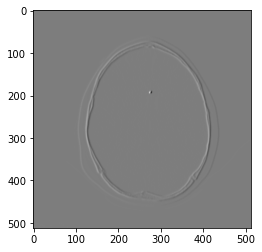

In [12]:
plot_edge_map(*get_edge_map(tens_img*tf.abs(tens_img)))

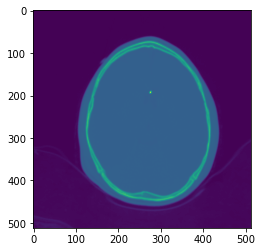

In [13]:
plb.imshow(img)

## (2) A scan with epidural hemorrhage

In [14]:
epidural = labels[labels['epidural']]
rand_img = epidural.index[np.random.randint(len(epidural))]
img = preprocess_dcm(img_dir+rand_img+'.dcm')
tens_img = tf.convert_to_tensor(np.expand_dims(img, axis=(0,3)))

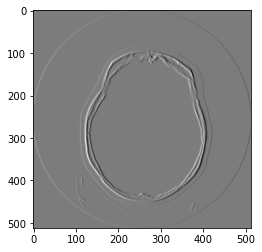

In [15]:
plot_edge_map(*get_edge_map(tens_img * tf.abs(tens_img)))

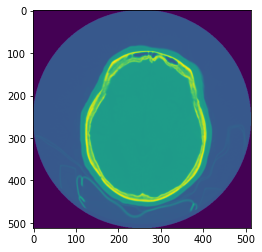

In [16]:
plb.imshow(img)

## (3) A scan with intraparenchymal hemorrhage

In [17]:
intraparenchymal = labels[labels['intraparenchymal']]
rand_img = intraparenchymal.index[np.random.randint(len(intraparenchymal))]
img = preprocess_dcm(img_dir+rand_img+'.dcm')
tens_img = tf.convert_to_tensor(np.expand_dims(img, axis=(0,3)))

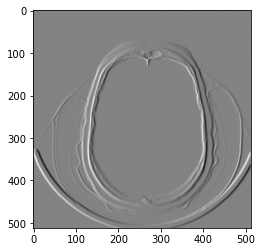

In [18]:
plot_edge_map(*get_edge_map(tens_img))

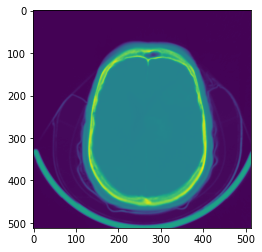

In [19]:
plb.imshow(img)

In [20]:
subarachnoid = labels[labels['subarachnoid']]
rand_img = subarachnoid.index[np.random.randint(len(subarachnoid))]
img = preprocess_dcm(img_dir+rand_img+'.dcm')
tens_img = tf.convert_to_tensor(np.expand_dims(img, axis=(0,3)))

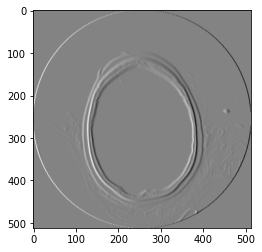

In [21]:
plot_edge_map(*get_edge_map(tens_img))

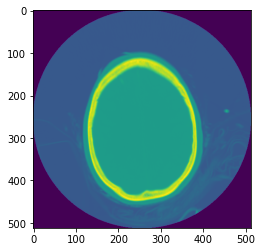

In [22]:
plb.imshow(img)

In [23]:
subdural = labels[labels['subdural']]
rand_img = subdural.index[np.random.randint(len(subdural))]
img = preprocess_dcm(img_dir+rand_img+'.dcm')
tens_img = tf.convert_to_tensor(np.expand_dims(img, axis=(0,3)))

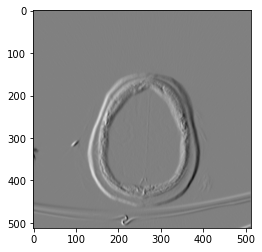

In [24]:
plot_edge_map(*get_edge_map(tens_img))

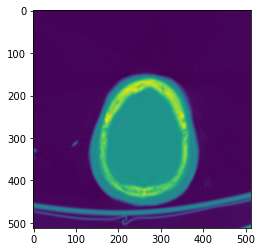

In [25]:
plb.imshow(img)

Overall, some basic exploration with edge detection using Sobel filters results in a hint that using such filters may help during classification